Адрес страницы - https://vk.com/ivanvashkovets

# Исследование факторов влияющих на количество лайков 

## Задача

1. Выполнить запрос по API к странице ВК с датой постов и количеством лайков. Сформировать таблицу из полученных данных;
2. К полученной таблице написать SQL-запросы для определения факторов в большей степени влияющих на количество лайков:
   
    - время суток публикации;
    - день недели;
    - промежуток между постами.

### Формирование таблицы

In [1]:
#импорт библиотек
import vk_api
import csv
import pandas as pd
from datetime import datetime
from pandasql import sqldf
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

In [2]:
#подключение API
token = '***'
vk_session = vk_api.VkApi(token=token)
vk = vk_session.get_api()

In [3]:
#получение id страницы
page_id = vk.users.get()[0]['id']

In [4]:
#получение списка всех постов
wall = vk.wall.get(owner_id=page_id, count=100)

In [5]:
#создание объекта
with open('posts.csv', 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['date', 'likes']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
#цикл по всем постам
    for post in wall['items']:
        #условие, что пост не является репостом или оставленным другим человеком
        if 'copy_history' not in post and post['from_id'] == page_id:
            post_date = datetime.fromtimestamp(post['date']).strftime('%Y-%m-%d %H:%M:%S')
            post_likes = post['likes']['count']
            writer.writerow({'date': post_date, 'likes': post_likes})

In [6]:
#чтение датафрейма
df = pd.read_csv('C:/Users/User/My Jupyter Projects/posts.csv').sort_values(by=['date'], ascending=False)
#чек
df.head()

,date,likes
1,2023-06-20 16:39:51,17
2,2023-03-15 22:32:44,14
3,2022-09-11 20:29:15,50
4,2022-03-14 22:08:35,36
5,2022-03-09 10:58:43,20


Из данных исключены посты, которые являлись перепостами или постами других людей на стене, ввиду того, что репосты меньше (либо вовсе) не транслируются в ленте, тем самым число лайков заметно меньше.

### SQL запросы

#### Влияние времени суток публикации на количество лайков

In [7]:
#запрос
query = '''
    SELECT strftime('%H', date) as hour, AVG(likes) likes
    FROM df
    GROUP BY strftime('%H', date)
'''
result = sqldf(query, locals())

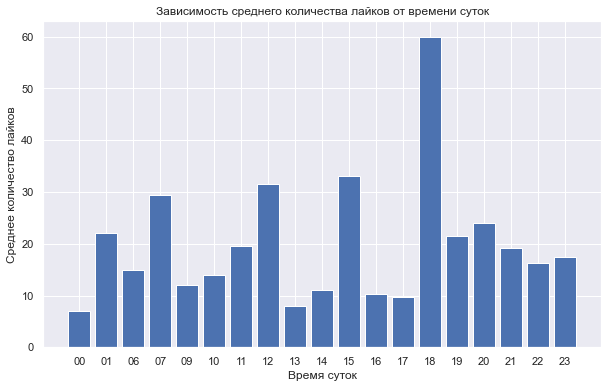

In [8]:
#визуализация
fig = plt.figure(figsize=(10, 6))
plt.bar(result.hour, result.likes)
plt.xlabel('Время суток')
plt.ylabel('Среднее количество лайков')
plt.title('Зависимость среднего количества лайков от времени суток')
plt.show()

Наибольшее число лайков приходится на 18:00, вероятно это связано с окончанием рабочего дня. с 2 до 5 утра - отсутствие активности. Также отмечаются всплески активности в 7, 12 и 15 часов. 

#### Влияние дня недели на количество лайков

In [9]:
#запрос
query2 = '''
    SELECT strftime('%w', date) as weekday, AVG(likes) likes
    FROM df
    GROUP BY strftime('%w', date)
'''
result2 = sqldf(query2, locals())

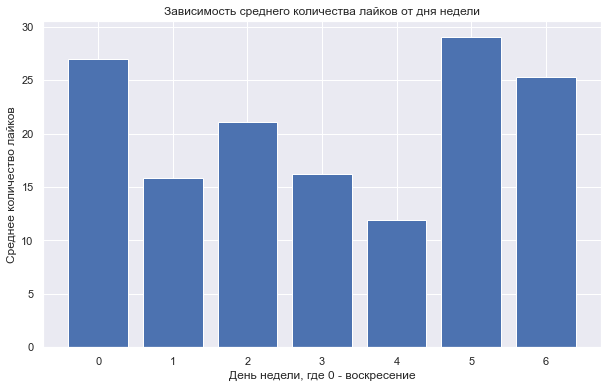

In [16]:
#визуализация
fig = plt.figure(figsize=(10, 6))
plt.bar(result2.weekday, result2.likes)
plt.xlabel('День недели, где 0 - воскресение')
plt.ylabel('Среднее количество лайков')
plt.title('Зависимость среднего количества лайков от дня недели')
plt.show()

Наибольшая активность отмечается в пятницу, также видно снижение активности от вторника к четвергу.

#### Влияние промежутка между постами на количество лайков

In [11]:
#запрос
query3 = '''
    SELECT days_interval, AVG(likes) AS likes
    FROM 
        (SELECT 
            julianday(date) - julianday((SELECT MAX(date) FROM df WHERE date < t.date)) AS days_interval,
            likes
        FROM 
            df t
        ) t
    GROUP BY days_interval;
'''
result3 = sqldf(query3, locals())

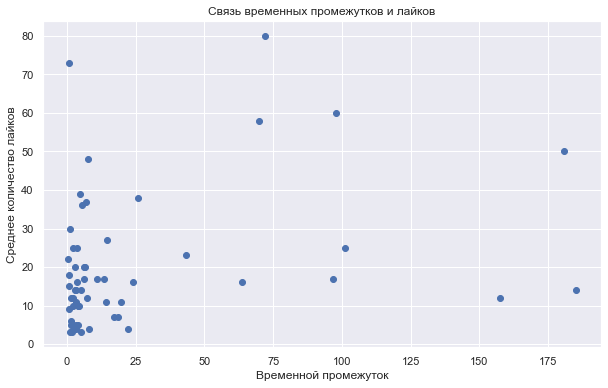

In [12]:
#визуализация
fig = plt.figure(figsize=(10, 6))
plt.scatter(result3['days_interval'], result3['likes'])
plt.xlabel('Временной промежуток')
plt.ylabel('Среднее количество лайков')
plt.title('Связь временных промежутков и лайков')
plt.show()

Наибольшее число событий в пределах 25 дней. 

In [13]:
#срез данных
temp = result3.query('likes < 50 & days_interval < 30')

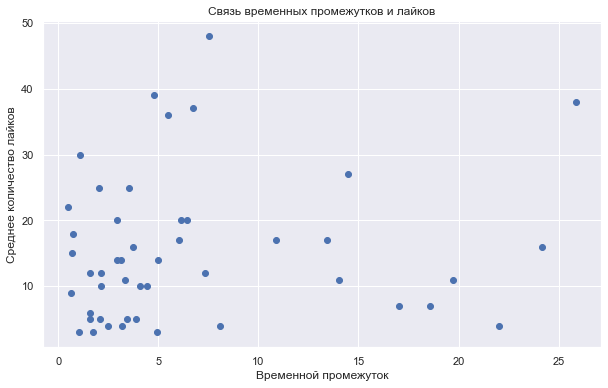

In [14]:
#визуализация
fig = plt.figure(figsize=(10, 6))
plt.scatter(temp['days_interval'], temp['likes'])
plt.xlabel('Временной промежуток')
plt.ylabel('Среднее количество лайков')
plt.title('Связь временных промежутков и лайков')
plt.show()

Утверждение, что увеличение временного промежут приводит к увеличению или уменьшению количества лайков не находит отражения. Вероятно, в связи с недостаточным числом событий (постов), а также в неравномерном их распределении.

## Общий вывод

Задачами данного исследование являлось получение данных по API из социальной сети VK, формирование таблицы, а также при помощи SQL-запросов определение факторов в наибольшей степени влияющих на количество лайков. Для исследования была использована страница https://vk.com/ivanvashkovets. Распределение публикаций имеет неравномерный характер и установить прямую зависимость между временным промежутком и числом лайков неудалось. Однако, отмечается увеличение числа лайков, в зависимости от времени суток и дня недели. Так наилучшие позицию по дню недели занимает - "пятница", а по времени суток - "18:00". Также отмечен тренд снижения пользовательской активности от вторника к четвергу.